In [844]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_breast_cancer
from torchimize.functions import lsq_lma

In [845]:
device = torch.device('cpu')
# For data preprocessing. To be replcaed with AR section.
cancer_data = pd.read_csv('/Users/waldo/Documents/23 HT/Data Mining 1DL370/Assignment4/cancer.csv',sep=';')
cancer_data.iloc[cancer_data['diagnosis'] == 'M',1] = 1
cancer_data.iloc[cancer_data['diagnosis'] == 'B',1] = 0
cancer_benign = cancer_data[cancer_data['diagnosis'] == 0]

X, y = cancer_data.iloc[:,2:], cancer_data.iloc[:,1]
X_normed = pd.DataFrame(MinMaxScaler().fit_transform(X))
X = X_normed.astype('float')
y = y.astype('float')
X = X.values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

In [846]:
print(X_train.shape)

torch.Size([455, 32])


In [847]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.input_layer = nn.Linear(32, 11)  # 32 input neurons to 11 hidden neurons. This will be changed to actual number of features.
        self.hidden_layer = nn.Linear(11, 1)  # 11 hidden neurons to 1 output neuron
    
    def forward(self, x):
        x = torch.tanh(self.input_layer(x))  # Apply tanh activation to the input layer
        x = torch.sigmoid(self.hidden_layer(x))  # Apply sigmoid activation to the output layer for binary classification
        return x

In [848]:
# Initialize the model
model = MLP()
model = model.to(device)

criterion = nn.MSELoss()

#for name, param in model.named_parameters():
    #print(name, param)

# Define the optimizer (Adam optimizer). To be changed to Lev-Mar
optimizer = optim.Adam(model.parameters(), lr=0.1)


In [849]:
num_epochs = 44

for epoch in range(num_epochs):
    outputs = model(X_train)
    loss = criterion(outputs, y_train.view(-1, 1))
    #print(loss)
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()  # Update weights
    
    #if (epoch + 1) % 1000 == 0:
       # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
print("Training completed")


Training completed


In [850]:
# Evaluate the model

with torch.no_grad():
    model.eval()
    predictions = model(X_test)
    predictions = (predictions > 0.5).float()
    accuracy = torch.sum(predictions.view(-1) == y_test).item() / y_test.size(0)
    print(f'Accuracy on test data: {accuracy:.4f}')



Accuracy on test data: 0.9737


In [851]:
"""
loss_list = []

class LevenbergMarquardtOptimizer:
    def __init__(self, model, target_func, initial_params, lambda_=0.01, max_iterations=50):
        self.model = model
        self.target_func = target_func
        self.params = torch.nn.Parameter(torch.tensor(initial_params, requires_grad=True))
        self.lambda_ = lambda_
        self.max_iterations = max_iterations

    def optimize(self):
        optimizer = torch.optim.SGD([self.params], lr=0.01)  # Dummy optimizer, as we manually perform updates
        
        for iteration in range(self.max_iterations):
            optimizer.zero_grad()
            loss = self.target_func(self.model(self.params))
            loss_list.append(loss)
            print(loss)
            loss.backward()

            # Compute the approximate Hessian matrix
            with torch.no_grad():
                approx_hessian = torch.autograd.functional.hessian(self.target_func, self.params)
                diag_values = approx_hessian.diagonal() + self.lambda_
            # Update parameters using LM formula: theta_new = theta - (H + lambda*I)^(-1) * gradient
            update = torch.linalg.solve(approx_hessian + torch.diag(diag_values), -self.params.grad)
            self.params.data += update

        return self.params.data.numpy()

# Example usage:

# Define your target function and model appropriately
def target_func(output):
    # Define your loss function here, for example, mean squared error
    loss = torch.mean((output - y_train.view(-1, 1))**2)
    return loss

# Instantiate your model and Levenberg-Marquardt optimizer
model = MLP()
initial_params = torch.empty(X_train.shape[1])
initial_params = nn.init.uniform_(initial_params)
#initial_params = torch.tensor([1.0] * 375)  # Initial guess for parameters
lm_optimizer = LevenbergMarquardtOptimizer(model, target_func, model.parameters())

# Perform optimization
optimized_params = lm_optimizer.optimize()
"""


'\nloss_list = []\n\nclass LevenbergMarquardtOptimizer:\n    def __init__(self, model, target_func, initial_params, lambda_=0.01, max_iterations=50):\n        self.model = model\n        self.target_func = target_func\n        self.params = torch.nn.Parameter(torch.tensor(initial_params, requires_grad=True))\n        self.lambda_ = lambda_\n        self.max_iterations = max_iterations\n\n    def optimize(self):\n        optimizer = torch.optim.SGD([self.params], lr=0.01)  # Dummy optimizer, as we manually perform updates\n        \n        for iteration in range(self.max_iterations):\n            optimizer.zero_grad()\n            loss = self.target_func(self.model(self.params))\n            loss_list.append(loss)\n            print(loss)\n            loss.backward()\n\n            # Compute the approximate Hessian matrix\n            with torch.no_grad():\n                approx_hessian = torch.autograd.functional.hessian(self.target_func, self.params)\n                diag_values = a

In [852]:
from torch.optim import Optimizer


def target_func(output):
    return criterion(outputs, y_train.view(-1, 1))

class LevenbergMarquardt(Optimizer):
    def __init__(self, params, lr=1, lambda_=0.01):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if lambda_ < 0.0:
            raise ValueError("Invalid lambda value: {}".format(lambda_))
        
        defaults = dict(lr=lr, lambda_=lambda_)
        super(LevenbergMarquardt, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()
                
        for group in self.param_groups:
            for param in group['params']:
                if param.grad is None:
                    continue

                lr = group['lr']
                lambda_ = group['lambda_']
                if len(param.shape) == 2:
                    d_p = param.grad
                    d_p = torch.reshape(d_p, (-1,))
                    shape0, shape1 = param.shape[0],param.shape[1]
                    param = torch.reshape(param, (-1,))
                    # Compute the approximate Hessian matrix (second derivative)
                    approx_hessian = torch.autograd.functional.hessian(func=target_func,inputs=param,create_graph=True)
                    diag_values = torch.diag(approx_hessian) + lambda_
                    # Update parameters using LM formula: theta_new = theta - (H + lambda*I)^(-1) * gradient
                    update = torch.linalg.solve(approx_hessian + torch.diag(diag_values), -d_p)
                    param.data += lr * update
                    param = torch.reshape(param,(shape0,shape1))
                else:
                    d_p = param.grad
                    approx_hessian = torch.autograd.functional.hessian(func=target_func,inputs=param,create_graph=True)
                    diag_values = torch.diag(approx_hessian) + lambda_
                    # Update parameters using LM formula: theta_new = theta - (H + lambda*I)^(-1) * gradient
                    update = torch.linalg.solve(approx_hessian + torch.diag(diag_values), -d_p)
                    param.data += lr * update

        return loss

model = MLP()
lm_optimizer = LevenbergMarquardt(model.parameters(), lr=0.001, lambda_=0.001)
loss_list = []
num_epochs = 200
for epoch in range(num_epochs):
    outputs = model(X_train)
    loss = criterion(outputs, y_train.view(-1, 1))      
    loss_list.append(loss.item())  
    lm_optimizer.zero_grad()
    loss.backward()
    lm_optimizer.step()
    if epoch%10 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [1/200], Loss: 0.2608
Epoch [11/200], Loss: 0.2030
Epoch [21/200], Loss: 0.1426
Epoch [31/200], Loss: 0.0940
Epoch [41/200], Loss: 0.0702
Epoch [51/200], Loss: 0.0581
Epoch [61/200], Loss: 0.0509
Epoch [71/200], Loss: 0.0461
Epoch [81/200], Loss: 0.0425
Epoch [91/200], Loss: 0.0397
Epoch [101/200], Loss: 0.0375
Epoch [111/200], Loss: 0.0356
Epoch [121/200], Loss: 0.0340
Epoch [131/200], Loss: 0.0327
Epoch [141/200], Loss: 0.0315
Epoch [151/200], Loss: 0.0304
Epoch [161/200], Loss: 0.0294
Epoch [171/200], Loss: 0.0286
Epoch [181/200], Loss: 0.0278
Epoch [191/200], Loss: 0.0271


In [853]:
with torch.no_grad():
    model.eval()
    predictions = model(X_test)
    predictions = (predictions > 0.5).float()
    accuracy = torch.sum(predictions.view(-1) == y_test).item() / y_test.size(0)
    print(f'Accuracy on test data: {accuracy:.4f}')

Accuracy on test data: 0.9649


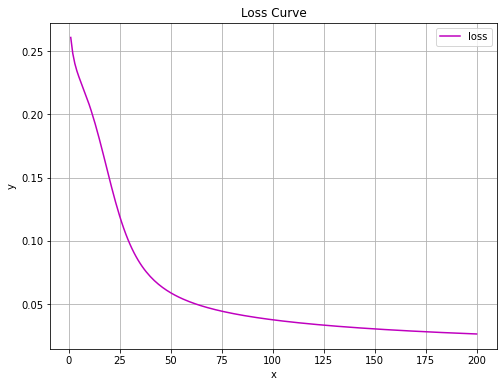

In [854]:
import matplotlib.pyplot as plt

x = np.linspace(1, len(loss_list) ,len(loss_list))
y = loss_list

plt.figure(figsize=(8, 6))
plt.plot(x, y, label='loss', color='m', linewidth=1.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
plt.show()
